# Stroke Prediction and Analysis

Classification by EscapeFromF

# Design

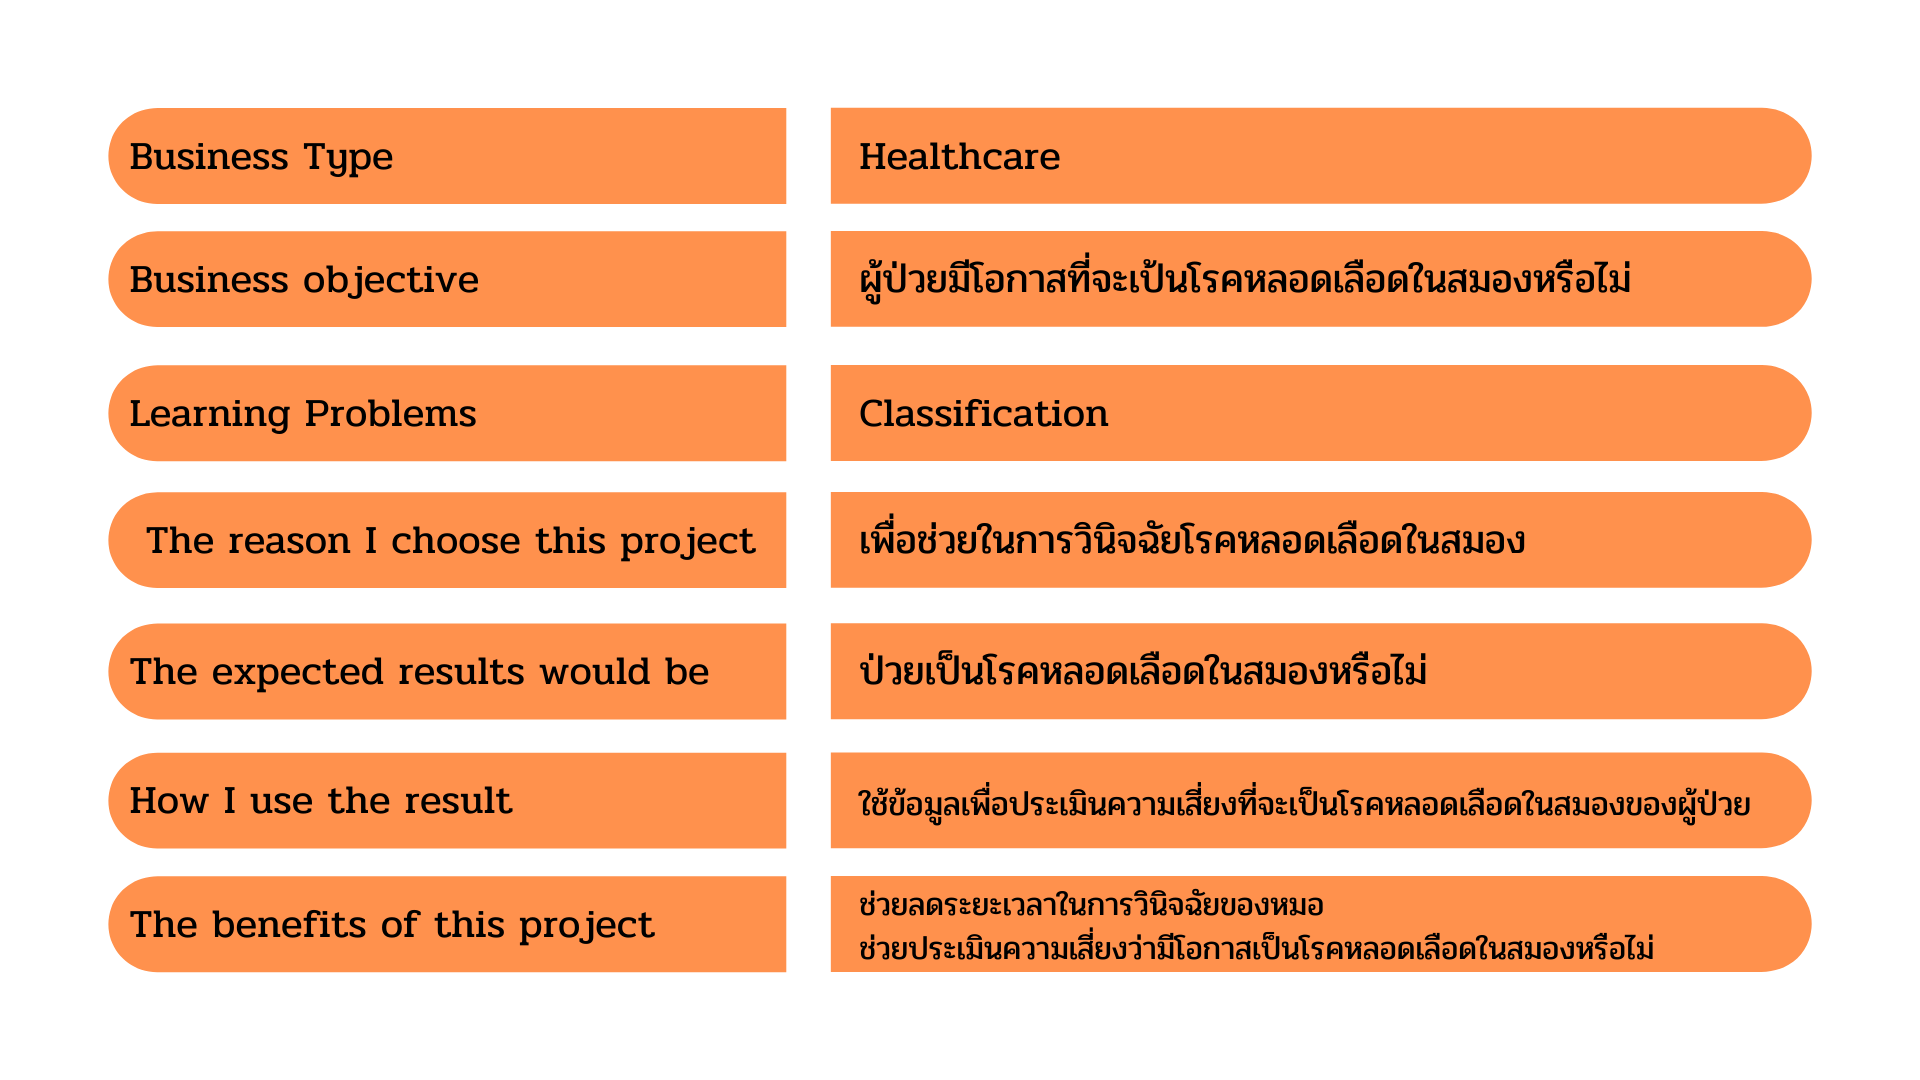

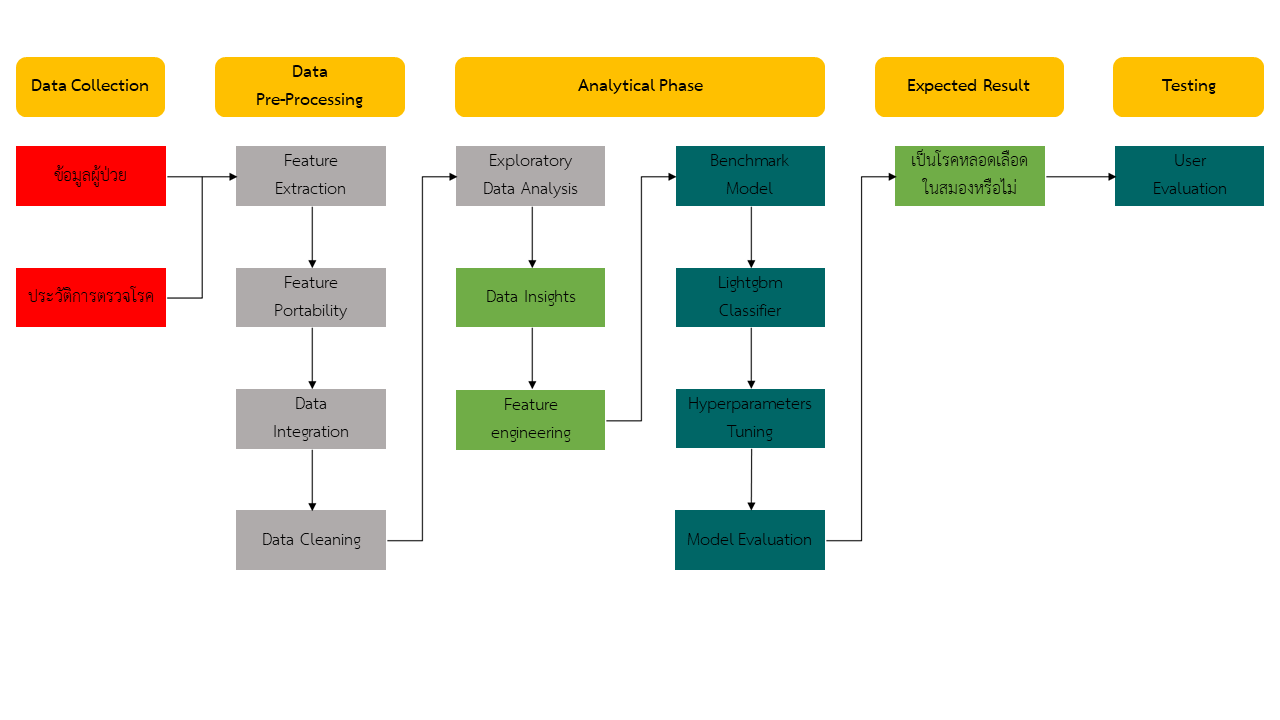

# Import

## Imports library

In [545]:
pip install scikit-plot

In [546]:
import numpy as np
import pandas as pd

# Charts
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix

# Models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgbm

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

# Scoring
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix

# Hyperparameters
from sklearn.model_selection import GridSearchCV

# remove verison errors
import warnings
warnings.filterwarnings('ignore')

# set style
sns.set_style("whitegrid")

## Import dataset

In [547]:
url = 'https://raw.githubusercontent.com/Sp1cky/CS434Final/main/healthcare-dataset-stroke-data.csv'
df_stroke = pd.read_csv(url)

# Data Preprocessing

## Data Check

In [548]:
df_stroke.sample(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
4574,32571,Male,33.0,0,0,Yes,Private,Urban,85.27,25.8,Unknown,0
1398,33983,Male,75.0,0,0,Yes,Govt_job,Rural,206.33,26.8,never smoked,0
3150,69979,Male,73.0,0,0,Yes,Self-employed,Rural,231.43,23.0,smokes,0
2437,19088,Male,8.0,0,0,No,children,Urban,105.63,19.2,Unknown,0
693,51514,Female,13.0,0,0,No,children,Urban,131.51,41.7,never smoked,0


About this dataset

- `id`: เลขประจำตัวคนไข้
- `gender`: "Male", "Female" or "Other"
- `age`: อายุ
- `hypertension`: 0 ไม่เป็นโรคความดันโลหิตสูง, 1 เป็นโรคความดันโลหิตสูง
- `heart_disease`: 0 ไม่เป็นโรคหัวใจ, 1 เป็นโรคหัวใจ
- `ever_married`: "No" or "Yes"
- `work_type`: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
- `Residence_type`: "Rural" or "Urban"
- `avg_glucose_level`: ค่าน้ำตาลในเลือดโดยเฉลี่ย
- `bmi`: body mass index
- `smoking_status`: "formerly smoked", "never smoked", "smokes" or "Unknown"
- `stroke`: 0 ไม่เป็นโรคหลอดเลือดในสมอง, 1 เป็นโรคหลอดเลือดในสมอง

In [549]:
# The size of the dataset
df_stroke.shape

(5110, 12)

In [550]:
# Basic info about data
df_stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [551]:
# Checking missing values
df_stroke.isnull().sum().sum()

201

In [552]:
# Checking duplicates
df_stroke.duplicated().sum()

0

## Data Cleaning

In [553]:
# Removing missing values
df_stroke.dropna(inplace=True)

# Removing Other Gender
df_stroke = df_stroke.drop(df_stroke[df_stroke.gender=='Other'].index)

In [554]:
# divide features to categorical, continous and label columns
categorical_cols = [ 'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'] # 7 col
continous_cols = ['age', 'avg_glucose_level', 'bmi'] # 3 col
label_col = ['stroke'] # 1 col

to_numeric = {
    'gender':{'Male': 0, 'Female': 1},
    'ever_married':{'No':0, 'Yes':1},
    'work_type': {'children': 0, 'Govt_job': 1, 'Never_worked': 2, 'Private': 3, 'Self-employed': 4},
    'Residence_type': {'Rural': 0, 'Urban': 1},
    'smoking_status': {'formerly smoked': 0, 'never smoked': 1, 'smokes': 2, 'Unknown': 3}
}

# Exploratory Data Analysis (EDA)

## Statistics Continous columns

In [555]:
df_stroke[continous_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,4908.0,42.868810,22.556128,0.08,25.0000,44.00,60.000,82.00
avg_glucose_level,4908.0,105.297402,44.425550,55.12,77.0675,91.68,113.495,271.74
bmi,4908.0,28.894560,7.854320,10.30,23.5000,28.10,33.100,97.60


## Distribution of Continuous

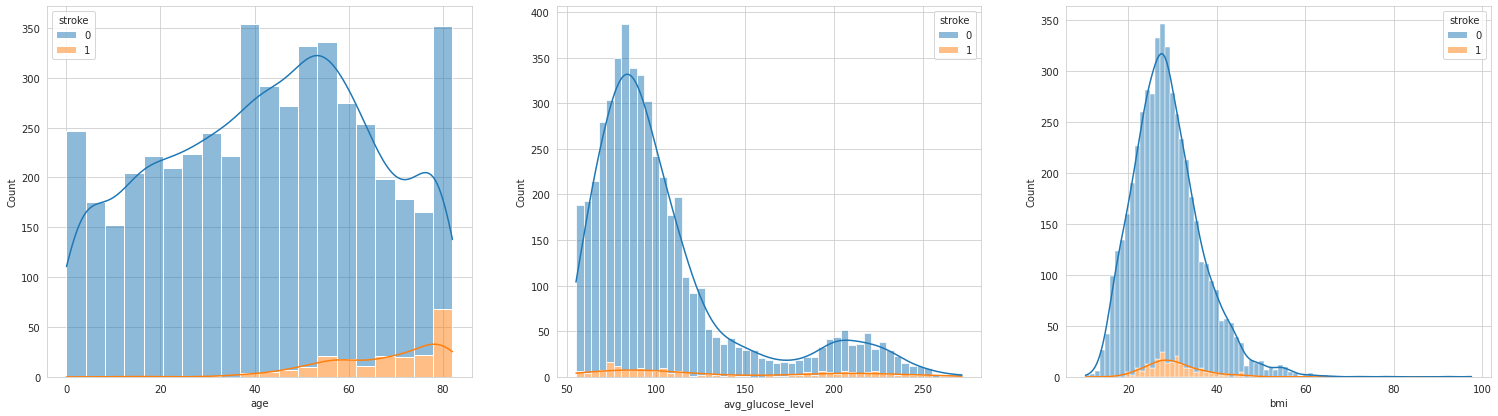

In [556]:
plt.figure(figsize = (35, 15))
cnt = 1

for i in range(len(continous_cols)):
    if cnt <= 3:
        ax = plt.subplot(2, 4, cnt)
        sns.histplot(df_stroke, x=continous_cols[i], hue="stroke", multiple="stack", kde=True, ax = ax)
    cnt += 1

plt.show()

## Barplot of the Categorical

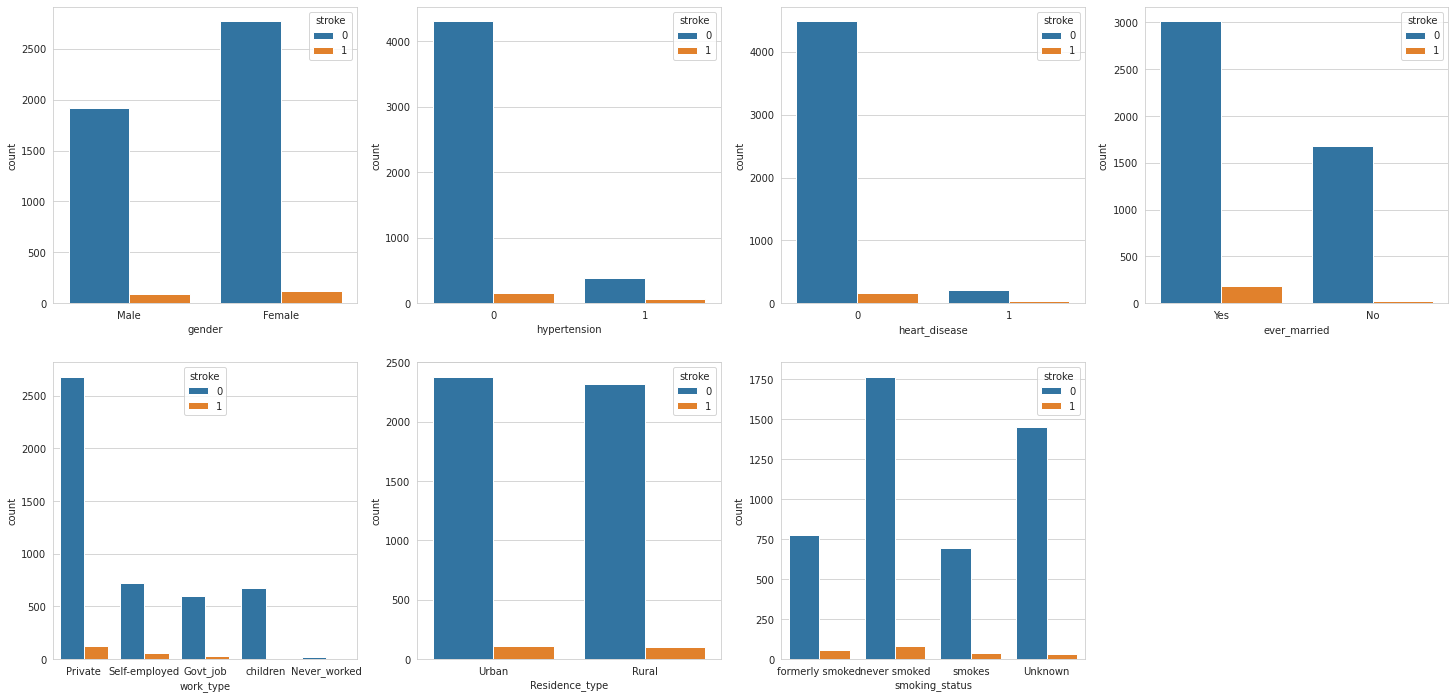

In [557]:
plt.figure(figsize = (25, 12))
cnt = 1

for i in range(len(categorical_cols)):
    if cnt <= 7:
        ax = plt.subplot(2, 4, cnt)
        sns.countplot(x = categorical_cols[i], hue='stroke', data = df_stroke, ax = ax)
        
    cnt += 1

plt.show()

## Count of the target

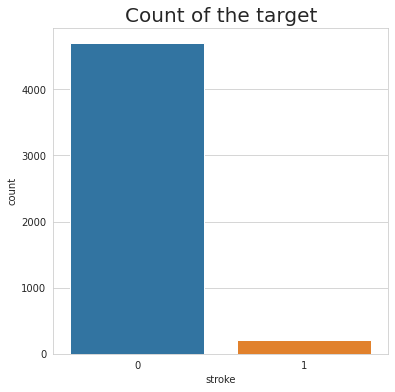

In [558]:
plt.figure(figsize = (6, 6))
plt.title('Count of the target', size=20)
sns.countplot(x="stroke", data=df_stroke)

# Feature Engineering

## Smote Benchmark

In [559]:
smote_count = []

In [560]:
# Copy dataset
df_stroke_tr = df_stroke.copy()
df_stroke_tr = df_stroke_tr.drop(columns=['id'])

In [561]:
# Encoding
for x in categorical_cols:
    if x in to_numeric:
        df_stroke_tr[x] = df_stroke_tr[x].map(lambda a: to_numeric[x][a])

In [562]:
df_stroke_tr.sample(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1234,0,53.0,0,0,1,1,0,78.73,23.3,1,0
1369,0,40.0,0,0,1,3,0,56.07,26.6,1,0
2940,1,73.0,1,1,1,1,1,67.38,32.8,0,0
2081,0,63.0,0,0,1,1,0,231.69,56.1,0,0
278,1,70.0,0,0,1,4,0,214.45,31.2,1,0
657,1,4.0,0,0,0,0,1,107.25,12.0,3,0
686,0,32.0,0,0,0,3,1,94.34,30.2,0,0
3147,0,55.0,0,0,1,3,1,108.64,29.5,1,0
4782,1,23.0,0,0,0,3,0,165.36,21.9,2,0
5042,0,32.0,0,0,0,3,0,100.65,26.2,0,0


In [563]:
X = df_stroke_tr.drop(['stroke'],axis=1)
y = df_stroke_tr['stroke']

In [564]:
sm_name = 'sampling_strategy=0.2'
sm1_before = sum(y==1)
sm0_before = sum(y==0)

sm = SMOTE(sampling_strategy=0.2, random_state=42)
X,y = sm.fit_resample(X, y)

sm1_after = sum(y==1)
sm0_after = sum(y==0)

smote_count.append({'SMOTE': sm_name, '1 Before SMOTE':sm1_before, '1 After SMOTE': sm1_after, '0 Before SMOTE':sm0_before, '0 After SMOTE': sm0_after})

In [565]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2021, stratify=y)

In [566]:
smote_model1 = lgbm.LGBMClassifier(n_estimators = 300, max_depth = 2, subsample=0.8, random_state=2021)
smote_model1.fit(X_train, y_train)
smote_pred1 = smote_model1.predict(X_test)
print('SMOTE sampling_strategy=0.2 \n',classification_report(y_test,smote_pred1))

SMOTE sampling_strategy=0.2 
               precision    recall  f1-score   support

           0       0.91      0.96      0.94       940
           1       0.72      0.55      0.62       188

    accuracy                           0.89      1128
   macro avg       0.82      0.75      0.78      1128
weighted avg       0.88      0.89      0.88      1128



In [567]:
sm_name = 'sampling_strategy=0.4'

sm = SMOTE(sampling_strategy=0.4, random_state=42)
X,y = sm.fit_resample(X, y)

sm1_after = sum(y==1)
sm0_after = sum(y==0)

smote_count.append({'SMOTE': sm_name, '1 Before SMOTE':sm1_before, '1 After SMOTE': sm1_after, '0 Before SMOTE':sm0_before, '0 After SMOTE': sm0_after})

In [568]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2021, stratify=y)

In [569]:
smote_model2 = lgbm.LGBMClassifier(n_estimators = 300, max_depth = 2, subsample=0.8, random_state=2021)
smote_model2.fit(X_train, y_train)
smote_pred2 = smote_model2.predict(X_test)
print('SMOTE sampling_strategy=0.4 \n',classification_report(y_test,smote_pred2))

SMOTE sampling_strategy=0.4 
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       940
           1       0.82      0.76      0.79       376

    accuracy                           0.88      1316
   macro avg       0.86      0.85      0.85      1316
weighted avg       0.88      0.88      0.88      1316



In [570]:
sm_name = 'sampling_strategy=0.6'

sm = SMOTE(sampling_strategy=0.6, random_state=42)
X,y = sm.fit_resample(X, y)

sm1_after = sum(y==1)
sm0_after = sum(y==0)

smote_count.append({'SMOTE': sm_name, '1 Before SMOTE':sm1_before, '1 After SMOTE': sm1_after, '0 Before SMOTE':sm0_before, '0 After SMOTE': sm0_after})

In [571]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2021, stratify=y)

In [572]:
smote_model3 = lgbm.LGBMClassifier(n_estimators = 300, max_depth = 2, subsample=0.8, random_state=2021)
smote_model3.fit(X_train, y_train)
smote_pred3 = smote_model3.predict(X_test)
print('SMOTE sampling_strategy=0.6 \n',classification_report(y_test,smote_pred3))

SMOTE sampling_strategy=0.6 
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       940
           1       0.84      0.88      0.86       564

    accuracy                           0.89      1504
   macro avg       0.88      0.89      0.89      1504
weighted avg       0.89      0.89      0.89      1504



In [573]:
smote_confusion_matrix = [smote_model1, smote_model2, smote_model3]

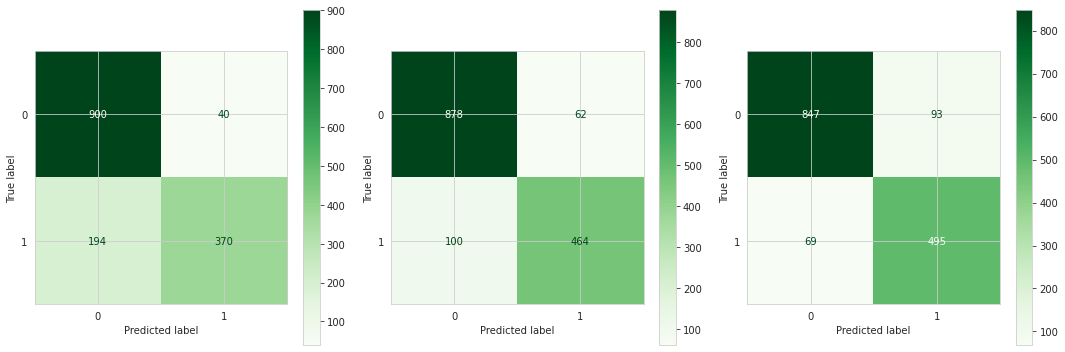

In [574]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for cls, ax in zip(smote_confusion_matrix, axes.flatten()):
    plot_confusion_matrix(cls, X_test, y_test, ax=ax, cmap='Greens')
plt.tight_layout()
plt.show()

In [575]:
sm_scores = pd.DataFrame(smote_count)
sm_scores

,SMOTE,1 Before SMOTE,1 After SMOTE,0 Before SMOTE,0 After SMOTE
0,sampling_strategy=0.2,209,939,4699,4699
1,sampling_strategy=0.4,209,1879,4699,4699
2,sampling_strategy=0.6,209,2819,4699,4699


In [576]:
X = df_stroke_tr.drop(['stroke'],axis=1)
y = df_stroke_tr['stroke']

In [577]:
# SMOTE
sm = SMOTE(sampling_strategy=0.6, random_state=42)
X,y = sm.fit_resample(X, y)

## Split data

In [578]:
# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2021, stratify=y)

# Raw
X_train_raw = X_train.copy()
X_test_raw = X_test.copy()
y_train_raw = y_train.copy()
y_test_raw = y_test.copy()

# Normalization
X_train_norm = X_train.copy()
X_test_norm = X_test.copy()
y_train_norm = y_train.copy()
y_test_norm = y_test.copy()
norm = MinMaxScaler()
X_train_norm[continous_cols] = norm.fit_transform(X_train_norm[continous_cols])
X_test_norm[continous_cols] = norm.transform(X_test_norm[continous_cols])

# Standardization
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()
y_train_stand = y_train.copy()
y_test_stand = y_test.copy()
scaler = StandardScaler()
X_train_stand[continous_cols] = scaler.fit_transform(X_train_stand[continous_cols])
X_test_stand[continous_cols] = scaler.transform(X_test_stand[continous_cols])

In [579]:
feature_scaling = {
    'Raw':(X_train_raw, X_test_raw, y_train_raw, y_test_raw),
    'Normalization':(X_train_norm, X_test_norm, y_train_norm, y_test_norm),
    'Standardization':(X_train_stand, X_test_stand, y_train_stand, y_test_stand),
}

In [580]:
# Test Model Functions
def train_model(model, X, y):
    model.fit(X, y)
    return model


def predict_model(model, X, proba=False):
    if ~proba:
        y_pred = model.predict(X)
    else:
        y_pred_proba = model.predict_proba(X)
        y_pred = np.argmax(y_pred_proba, axis=1)

    return y_pred


list_scores = []

def run_model(name, model, X_train, X_test, y_train, y_test, fc, proba=False):
    print(name)
    print(fc)
    
    model = train_model(model, X_train, y_train)
    y_pred = predict_model(model, X_test, proba)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print('accuracy: ', accuracy)
    print('recall: ',recall)
    print('precision: ', precision)
    print('f1: ', f1)
    print(classification_report(y_test, y_pred))
    
    
    list_scores.append({'Model Name': name, 'Feature Scaling':fc, 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1':f1})

# Modeling

## Benchmark

In [581]:
model_svc = SVC(random_state=2021)

for fc_name, value in feature_scaling.items():
    X_train, X_test, y_train, y_test = value
    run_model('SVC', model_svc, X_train, X_test, y_train, y_test, fc_name)

SVC
Raw
accuracy:  0.7785904255319149
recall:  0.74822695035461
precision:  0.6884176182707994
f1:  0.7170773152081564
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       940
           1       0.69      0.75      0.72       564

    accuracy                           0.78      1504
   macro avg       0.76      0.77      0.77      1504
weighted avg       0.78      0.78      0.78      1504

SVC
Normalization
accuracy:  0.8184840425531915
recall:  0.7411347517730497
precision:  0.7669724770642202
f1:  0.7538322813345356
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       940
           1       0.77      0.74      0.75       564

    accuracy                           0.82      1504
   macro avg       0.81      0.80      0.81      1504
weighted avg       0.82      0.82      0.82      1504

SVC
Standardization
accuracy:  0.8410904255319149
recall:  0.8031914893617021
precision:  0.7796

In [582]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=2021)

for fc_name, value in feature_scaling.items():
    X_train, X_test, y_train, y_test = value
    run_model('Logistic Regression', logreg, X_train, X_test, y_train, y_test, fc_name, proba=True)

Logistic Regression
Raw
accuracy:  0.807845744680851
recall:  0.75
precision:  0.7408056042031523
f1:  0.745374449339207
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       940
           1       0.74      0.75      0.75       564

    accuracy                           0.81      1504
   macro avg       0.79      0.80      0.80      1504
weighted avg       0.81      0.81      0.81      1504

Logistic Regression
Normalization
accuracy:  0.8065159574468085
recall:  0.7429078014184397
precision:  0.7415929203539823
f1:  0.7422497785651018
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       940
           1       0.74      0.74      0.74       564

    accuracy                           0.81      1504
   macro avg       0.79      0.79      0.79      1504
weighted avg       0.81      0.81      0.81      1504

Logistic Regression
Standardization
accuracy:  0.8091755319148937
recall:  0.7

In [583]:
for fc_name, value in feature_scaling.items():
    X_train, X_test, y_train, y_test = value
    
    dt = DecisionTreeClassifier()
    
    parameters = { 'max_depth':np.arange(1,5,1),'random_state':[2021]}
    searcher = GridSearchCV(dt, parameters)
    
    run_model('DecisionTree Classifier', searcher, X_train, X_test, y_train, y_test, fc_name )

DecisionTree Classifier
Raw
accuracy:  0.7878989361702128
recall:  0.7358156028368794
precision:  0.7094017094017094
f1:  0.72236727589208
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       940
           1       0.71      0.74      0.72       564

    accuracy                           0.79      1504
   macro avg       0.77      0.78      0.78      1504
weighted avg       0.79      0.79      0.79      1504

DecisionTree Classifier
Normalization
accuracy:  0.7878989361702128
recall:  0.7358156028368794
precision:  0.7094017094017094
f1:  0.72236727589208
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       940
           1       0.71      0.74      0.72       564

    accuracy                           0.79      1504
   macro avg       0.77      0.78      0.78      1504
weighted avg       0.79      0.79      0.79      1504

DecisionTree Classifier
Standardization
accuracy:  0.78789

In [584]:
rf = RandomForestClassifier(n_estimators=300, max_depth=2, random_state=2021)

for fc_name, value in feature_scaling.items():
    X_train, X_test, y_train, y_test = value
    run_model('RandomForest Classifier', rf, X_train, X_test, y_train, y_test, fc_name)

RandomForest Classifier
Raw
accuracy:  0.7918882978723404
recall:  0.6968085106382979
precision:  0.7345794392523365
f1:  0.7151956323930846
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       940
           1       0.73      0.70      0.72       564

    accuracy                           0.79      1504
   macro avg       0.78      0.77      0.78      1504
weighted avg       0.79      0.79      0.79      1504

RandomForest Classifier
Normalization
accuracy:  0.7918882978723404
recall:  0.6968085106382979
precision:  0.7345794392523365
f1:  0.7151956323930846
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       940
           1       0.73      0.70      0.72       564

    accuracy                           0.79      1504
   macro avg       0.78      0.77      0.78      1504
weighted avg       0.79      0.79      0.79      1504

RandomForest Classifier
Standardization
accuracy:  0.7

In [585]:
gbt = GradientBoostingClassifier(n_estimators = 300, max_depth=2, subsample=0.8, max_features=0.2, random_state=2021)
for fc_name, value in feature_scaling.items():
    X_train, X_test, y_train, y_test = value
    run_model('GradientBoosting Classifier', gbt, X_train, X_test, y_train, y_test, fc_name)

GradientBoosting Classifier
Raw
accuracy:  0.8517287234042553
recall:  0.8138297872340425
precision:  0.7954939341421143
f1:  0.8045574057843996
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       940
           1       0.80      0.81      0.80       564

    accuracy                           0.85      1504
   macro avg       0.84      0.84      0.84      1504
weighted avg       0.85      0.85      0.85      1504

GradientBoosting Classifier
Normalization
accuracy:  0.8517287234042553
recall:  0.8138297872340425
precision:  0.7954939341421143
f1:  0.8045574057843996
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       940
           1       0.80      0.81      0.80       564

    accuracy                           0.85      1504
   macro avg       0.84      0.84      0.84      1504
weighted avg       0.85      0.85      0.85      1504

GradientBoosting Classifier
Standardization
ac

In [586]:
for fc_name, value in feature_scaling.items():
    X_train, X_test, y_train, y_test = value
    xgb_model = xgb.XGBClassifier(n_estimators = 300, max_depth=2, random_state=2021, use_label_encoder=False, eval_metric='mlogloss')
        
    run_model('XGBoost Classifier', xgb_model, X_train, X_test, y_train, y_test, fc_name)

XGBoost Classifier
Raw
accuracy:  0.8736702127659575
recall:  0.8421985815602837
precision:  0.8246527777777778
f1:  0.8333333333333335
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       940
           1       0.82      0.84      0.83       564

    accuracy                           0.87      1504
   macro avg       0.86      0.87      0.87      1504
weighted avg       0.87      0.87      0.87      1504

XGBoost Classifier
Normalization
accuracy:  0.8736702127659575
recall:  0.8421985815602837
precision:  0.8246527777777778
f1:  0.8333333333333335
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       940
           1       0.82      0.84      0.83       564

    accuracy                           0.87      1504
   macro avg       0.86      0.87      0.87      1504
weighted avg       0.87      0.87      0.87      1504

XGBoost Classifier
Standardization
accuracy:  0.8736702127659575

In [587]:
lgbm_model = lgbm.LGBMClassifier(n_estimators = 300, max_depth = 2, subsample=0.8, random_state=2021)
for fc_name, value in feature_scaling.items():
    X_train, X_test, y_train, y_test = value
    run_model('Lightgbm Classifier', lgbm_model, X_train, X_test, y_train, y_test, fc_name)

Lightgbm Classifier
Raw
accuracy:  0.8730053191489362
recall:  0.8421985815602837
precision:  0.8232235701906413
f1:  0.8326029798422435
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       940
           1       0.82      0.84      0.83       564

    accuracy                           0.87      1504
   macro avg       0.86      0.87      0.87      1504
weighted avg       0.87      0.87      0.87      1504

Lightgbm Classifier
Normalization
accuracy:  0.8710106382978723
recall:  0.8351063829787234
precision:  0.8234265734265734
f1:  0.8292253521126761
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       940
           1       0.82      0.84      0.83       564

    accuracy                           0.87      1504
   macro avg       0.86      0.86      0.86      1504
weighted avg       0.87      0.87      0.87      1504

Lightgbm Classifier
Standardization
accuracy:  0.8769946808510

### Summary scores

In [588]:
df_scores = pd.DataFrame(list_scores)
df_scores.style.highlight_max(color = 'green', axis = 0)

,Model Name,Feature Scaling,Accuracy,Recall,Precision,F1
0,SVC,Raw,0.778590,0.748227,0.688418,0.717077
1,SVC,Normalization,0.818484,0.741135,0.766972,0.753832
2,SVC,Standardization,0.841090,0.803191,0.779690,0.791266
3,Logistic Regression,Raw,0.807846,0.750000,0.740806,0.745374
4,Logistic Regression,Normalization,0.806516,0.742908,0.741593,0.742250
5,Logistic Regression,Standardization,0.809176,0.750000,0.743409,0.746690
6,DecisionTree Classifier,Raw,0.787899,0.735816,0.709402,0.722367
7,DecisionTree Classifier,Normalization,0.787899,0.735816,0.709402,0.722367
8,DecisionTree Classifier,Standardization,0.787899,0.735816,0.709402,0.722367
9,RandomForest Classifier,Raw,0.791888,0.696809,0.734579,0.715196


## Evaluation

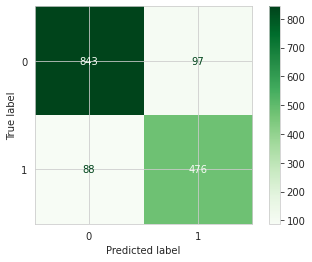

In [589]:
plot_confusion_matrix(lgbm_model, X_test, y_test, cmap='Greens');
plt.show()

## Hyperparameters Tuning

In [590]:
lgbm_params = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300, 400],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }
lgbm_tuning = GridSearchCV(lgbm.LGBMClassifier(), lgbm_params, scoring = 'recall',cv = 5)
lgbm_tuning.fit(X_train, y_train)
best_score = lgbm_tuning.best_score_
best_params = lgbm_tuning.best_params_
print ('Best Score is',best_score * 100)
print ('Best Parameters is', best_params)

Best Score is 93.61419068736141
Best Parameters is {'lambda_l1': 0, 'lambda_l2': 0, 'min_data_in_leaf': 30, 'num_leaves': 127, 'reg_alpha': 0.1}


In [591]:
lgbm_tuning.best_estimator_

LGBMClassifier(lambda_l1=0, lambda_l2=0, min_data_in_leaf=30, num_leaves=127,
               reg_alpha=0.1)

In [592]:
lightbgm_confusion_matrix = [lgbm_model, lgbm_tuning]

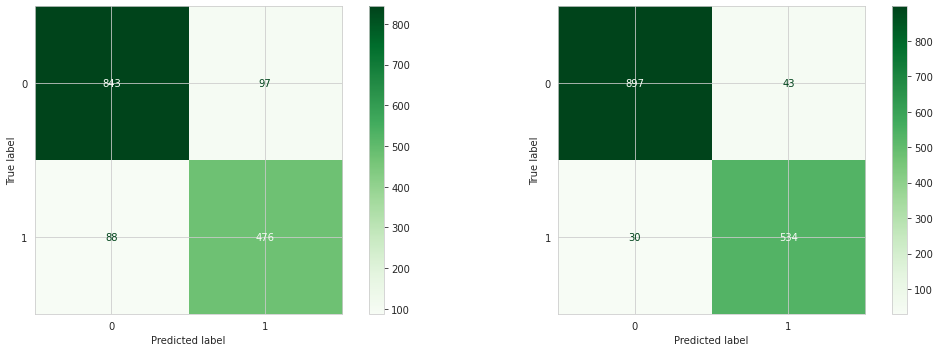

In [593]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

for cls, ax in zip(lightbgm_confusion_matrix, axes.flatten()):
    plot_confusion_matrix(cls, X_test, y_test, ax=ax, cmap='Greens',)

plt.tight_layout()
plt.show()

In [594]:
print(classification_report(y_test, 
                            lgbm_tuning.best_estimator_.predict(X_test),
                            target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       940
           1       0.93      0.95      0.94       564

    accuracy                           0.95      1504
   macro avg       0.95      0.95      0.95      1504
weighted avg       0.95      0.95      0.95      1504



In [595]:
lgbm_tuning.best_estimator_.predict_proba(X_test)[0][1]>.4

False

In [596]:
def cut_ratio(model, x_test, y_test, target):
  prid_ratio = model.best_estimator_.predict_proba(x_test)
  proba_df = pd.DataFrame(prid_ratio, columns=['0','1'])
  y_ratio = proba_df['1'].apply(lambda x: 1 if x > target else 0)
  return y_ratio

def report_ratio(model, x_test, y_test):
  targets = [.2,.3,.4]
  fig, ax = plt.subplots(1, 3, figsize=(20, 6))
  for enum,target in enumerate(targets):
    y_ratio = cut_ratio(model, x_test, y_test, target)
    sns.heatmap(confusion_matrix(y_test, y_ratio) ,annot=True, fmt="d", cbar=False, cmap="Greens",  ax = ax[enum]).set_ylim([2,0])
    ax[enum].set_title(f"cut ratio: {target}", weight='bold')
    ax[enum].set_xlabel('Predicted Labels')
    ax[enum].set_ylabel('Actual Labels')

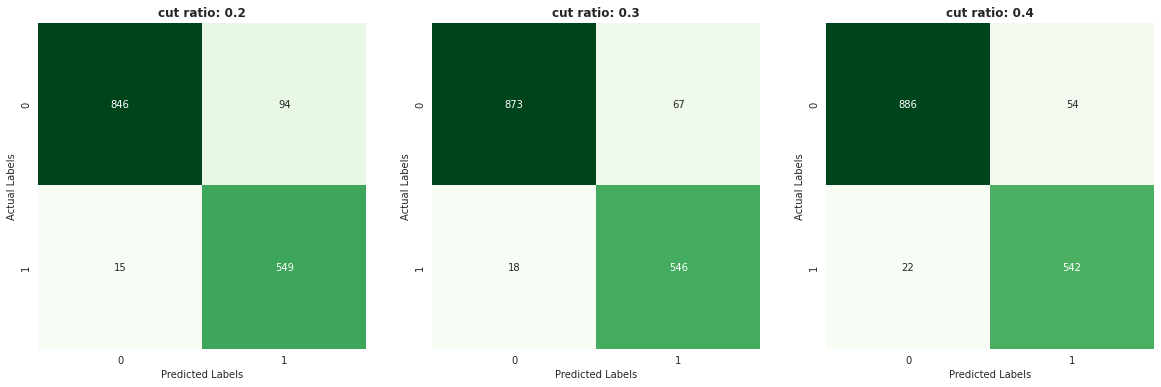

In [597]:
report_ratio(lgbm_tuning, X_test, y_test)

## Feature Importance

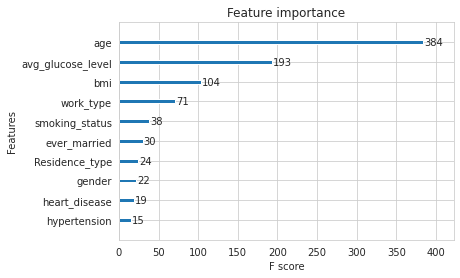

<Figure size 1152x864 with 0 Axes>

In [598]:
xgb.plot_importance(xgb_model)
plt.figure(figsize = (16, 12))
plt.show()

# Pipeline

In [599]:
class PipeLine():
  def __init__(self):
      self.mapping = {}
      self.columns = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status']
      self.target = 'stroke'
      self.scaler = StandardScaler()

  def encoding(self, data):
      data['gender'] = data['gender'].map({'Male': 0, 'Female': 1, 'Other': 2})
      data['ever_married'] = data['ever_married'].map({'No':0, 'Yes':1})
      data['work_type'] = data['work_type'].map({'children': 0, 'Govt_job': 1, 'Never_worked': 2, 'Private': 3, 'Self-employed': 4})
      data['Residence_type'] = data['Residence_type'].map({'Rural': 0, 'Urban': 1})
      data['smoking_status'] = data['smoking_status'].map({'formerly smoked': 0, 'never smoked': 1, 'smokes': 2, 'Unknown': 3})
      return data

  def build_trian(self, data):
      targets = data[self.target].copy()
      data = data[self.columns].copy()
      data = self.encoding(data)
      data = self.scaler.fit_transform(data)
      return data, targets
  
  def build_predict(self, data):
      data = data[self.columns].copy()
      data = self.encoding(data)
      return self.scaler.transform(data)

In [600]:
df_pipeline = df_stroke.copy()
pipeline = PipeLine()

In [601]:
# Train Model
X_deploy, y_deploy = pipeline.build_trian(df_pipeline)

In [602]:
# Tuning Model
lgbm_deploy = lgbm_tuning.best_estimator_

In [603]:
# Fit Model
lgbm_deploy.fit(X_deploy, y_deploy)

LGBMClassifier(lambda_l1=0, lambda_l2=0, min_data_in_leaf=30, num_leaves=127,
               reg_alpha=0.1)

## Test Predict #1

In [604]:
df_stroke.loc[df_stroke['id'] == 7371]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
69,7371,Female,80.0,1,0,Yes,Self-employed,Rural,72.67,28.9,never smoked,1


In [605]:
test_predict = pd.DataFrame({
        'gender': 'Female',
        'age': 80.00,
        'hypertension': 1,
        'heart_disease': 0,
        'ever_married': 'Yes',
        'work_type': 'Self-employed',
        'Residence_type': 'Rural' ,
        'avg_glucose_level': 72.67,
        'bmi': 28.9	,
        'smoking_status': 'never smoked'
    },index=[0])

In [606]:
lgbm_deploy.predict(pipeline.build_predict(test_predict))[0]

1

## Test Predict #2

In [607]:
df_stroke.loc[df_stroke['id'] == 1225]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2761,1225,Male,43.0,0,0,Yes,Private,Urban,87.82,38.8,formerly smoked,0


In [608]:
test_predict2 = pd.DataFrame({
        'gender': 'Male',
        'age': 43.0,
        'hypertension': 0,
        'heart_disease': 0,
        'ever_married': 'Yes',
        'work_type': 'Private',
        'Residence_type': 'Urban' ,
        'avg_glucose_level': 87.82,
        'bmi': 38.8,
        'smoking_status': 'formerly smoked'
    },index=[0])

In [609]:
lgbm_deploy.predict(pipeline.build_predict(test_predict2))[0]

0

# Deployment

In [610]:
!pip install gradio -q

In [611]:
import gradio as gr

In [612]:
def predict_stroke(gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status):

    # input dataframe
    input = pd.DataFrame({
        'gender': gender,
        'age': age,
        'hypertension': int(hypertension),
        'heart_disease': int(heart_disease),
        'ever_married': ever_married,
        'work_type': work_type,
        'Residence_type': Residence_type,
        'avg_glucose_level': avg_glucose_level,
        'bmi': bmi,
        'smoking_status': smoking_status
    },index=[0])

    # predict
    pred = lgbm_deploy.predict_proba(pipeline.build_predict(input))[0]
    return {'No Stroke': pred[0], 'Stroke': pred[1]}


# inputs
gender = gr.inputs.Radio(list(df_pipeline['gender'].unique()), label='gender')
age = gr.inputs.Textbox(placeholder='Enter your age', label='Age')
hypertension = gr.inputs.Radio([0,1], label='hypertension')
heart_disease = gr.inputs.Radio([0,1], label='heart_disease')
ever_married = gr.inputs.Radio(list(df_pipeline['ever_married'].unique()), label='ever_married')
work_type = gr.inputs.Dropdown(list(df_pipeline['work_type'].unique()), default='Private', label='work_type')
Residence_type = gr.inputs.Radio(list(df_pipeline['Residence_type'].unique()), label='Residence_type')
avg_glucose_level = gr.inputs.Textbox(placeholder='Enter Average Glucose', label='avg_glucose_level')
bmi = gr.inputs.Textbox(placeholder='Enter BMI', label='bmi')
smoking_status = gr.inputs.Dropdown(list(df_pipeline['smoking_status'].unique()), default='Unknown', label='smoking_status')

test_input = [['Female', 80.0, 1, 0, 'Yes', 'Self-employed', 'Rural' , 72.67, 28.9, 'never smoked'],
              ['Male', 43.0, 0, 0, 'Yes', 'Private', 'Urban' , 87.82, 38.8, 'formerly smoked'],
              ['Male', 69.0, 0, 0, 'Yes', 'Private', 'Rural', 93.81, 28.5, 'Unknown'],
              ['Female', 41.0, 0, 0, 'Yes', 'Govt_job', 'Rural', 78.93, 30.9, 'formerly smoked'],
              ['Male', 69.0, 0, 0, 'Yes', 'Private', 'Rural', 93.81, 28.5, 'Unknown']]


iface = gr.Interface(predict_stroke, 
                     inputs=[gender,
                             age,
                             hypertension,
                             heart_disease,
                             ever_married,
                             work_type,
                             Residence_type,
                             avg_glucose_level,
                             bmi,
                             smoking_status],
                     live=False,
                     outputs='label',
                     examples=test_input)
iface.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://40996.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7866/',
 'https://40996.gradio.app')

# Reference

Stroke [Dataset](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset)

EDA
*   [histplot](https://seaborn.pydata.org/generated/seaborn.histplot.html)
*   [countplot](https://seaborn.pydata.org/generated/seaborn.countplot.html)

Modeling
*   [Model Benchmark](https://www.kaggle.com/jedrzejdudzicz/stroke-prediction-and-analysis-f1-95?fbclid=IwAR3l9sFmK6SBnSv0TyxKvu-0jG-r4dRFfViVY4kGdO2SlkhQ4-plwtPEDbs)
*   [Hyperparameters Tuning & Feature Importance](https://github.com/pb111)




Project Reference
*   [กลุ่ม The Mythics](https://github.com/dear3089/CS434_Data_Mining_finalExam)
*   [กลุ่ม Random](https://github.com/teerayut-bee/CS434-DataMining)




# Created by

*   กันตภณ เชื้อนาคา 1620700771 (Developer)
*   ศิลป์ชัย วงษ์เพ็ญ 1620705655 (Visualizer)
*   ธนชาติ ทองพ่วง 1620704377 (Designer)

Special thank to

*   อาจารย์ ปฐมพล นิลชัยโกวิทย์



